In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import random
from torch.autograd import Variable


In [2]:
batch_size = 64
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#difine transforms
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])

# define the data loaders
data_loader = DataLoader(datasets.MNIST('', train=True, transform=transform),batch_size=batch_size, shuffle=True)

In [7]:
image, classe = random.choice(data_loader.dataset)
print(classe)
print(image)
transforms.ToPILImage()(image)

3
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [8]:
def noise(batch_size):
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    return z, fake_labels

In [9]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [10]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [11]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z, fake_labels = noise(batch_size)
    z = z.to(device)
    fake_labels = fake_labels.to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [12]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    z, fake_labels = noise(batch_size)
    z = z.to(device)
    fake_labels = fake_labels.to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [13]:
def show_images(generator, monitoring_noise):
    z = monitoring_noise[0].to(device)
    labels = monitoring_noise[1].to(device)
    with torch.no_grad():
        monitoring_generated_images = generator(z, labels).to("cpu")
    for image in monitoring_generated_images:
        
        display(transforms.ToPILImage()(image))

In [14]:
# generate a noise to monitor the model improvement
monitoring_noise = noise(5)

In [15]:
num_epochs = 10
history = {"d_loss":[], "g_loss":[]}
for epoch in range(num_epochs):
    d_loss = 0
    g_loss = 0
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):
        
        
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        
        d_loss += discriminator_train_step(len(real_images), discriminator, generator, d_optimizer, criterion, real_images, labels)
        g_loss += generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
        
    history["d_loss"].append(d_loss/i)
    history["g_loss"].append(g_loss/i)
    print('discriminator loss: {}'.format(d_loss/i), end=' ')
    print('generator loss: {}'.format(g_loss/i), end=' ')
    print('Done!')
    if epoch % 5 == 0:
        print(f"Epoch {epoch}")
        show_images(generator, monitoring_noise)
print("training is complete")

Starting epoch 0... 

RuntimeError: CUDA error: no kernel image is available for execution on the device

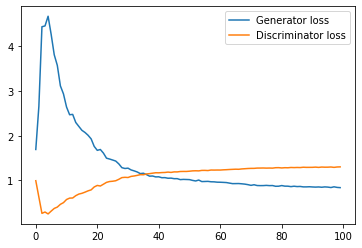

In [15]:
#plot loss
plt.figure()
plt.plot(history["g_loss"], label='Generator loss')
plt.plot(history["d_loss"], label='Discriminator loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [16]:
torch.save(generator.state_dict(), 'mnist_generator100.pt')